In [14]:
import numpy as np
import pandas as pd
import dask as dd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns


In [4]:
data = pd.read_csv('data/heart_attack_dataset.csv')


In [5]:
data.isna().sum()

Age                      0
Gender                   0
Cholesterol              0
BloodPressure            0
HeartRate                0
BMI                      0
Smoker                   0
Diabetes                 0
Hypertension             0
FamilyHistory            0
PhysicalActivity         0
AlcoholConsumption       0
Diet                     0
StressLevel              0
Ethnicity                0
Income                   0
EducationLevel           0
Medication               0
ChestPainType            0
ECGResults               0
MaxHeartRate             0
ST_Depression            0
ExerciseInducedAngina    0
Slope                    0
NumberOfMajorVessels     0
Thalassemia              0
PreviousHeartAttack      0
StrokeHistory            0
Residence                0
EmploymentStatus         0
MaritalStatus            0
Outcome                  0
dtype: int64

In [6]:
data.dtypes

Age                        int64
Gender                    object
Cholesterol                int64
BloodPressure              int64
HeartRate                  int64
BMI                      float64
Smoker                     int64
Diabetes                   int64
Hypertension               int64
FamilyHistory              int64
PhysicalActivity           int64
AlcoholConsumption         int64
Diet                      object
StressLevel                int64
Ethnicity                 object
Income                     int64
EducationLevel            object
Medication                object
ChestPainType             object
ECGResults                object
MaxHeartRate               int64
ST_Depression            float64
ExerciseInducedAngina     object
Slope                     object
NumberOfMajorVessels       int64
Thalassemia               object
PreviousHeartAttack        int64
StrokeHistory              int64
Residence                 object
EmploymentStatus          object
MaritalSta

In [7]:
categories = data.select_dtypes(include=['object'])
categories

,Gender,Diet,Ethnicity,EducationLevel,Medication,ChestPainType,ECGResults,ExerciseInducedAngina,Slope,Thalassemia,Residence,EmploymentStatus,MaritalStatus,Outcome
0,Male,Unhealthy,Hispanic,High School,Yes,Typical,ST-T abnormality,Yes,Downsloping,Normal,Suburban,Retired,Single,No Heart Attack
1,Male,Unhealthy,Asian,College,No,Atypical,LV hypertrophy,Yes,Upsloping,Normal,Suburban,Unemployed,Married,No Heart Attack
2,Female,Healthy,Black,College,No,Non-anginal,Normal,Yes,Upsloping,Normal,Rural,Retired,Single,Heart Attack
3,Male,Healthy,Hispanic,High School,Yes,Atypical,ST-T abnormality,Yes,Flat,Reversible defect,Suburban,Retired,Widowed,No Heart Attack
4,Female,Moderate,Hispanic,High School,Yes,Typical,ST-T abnormality,Yes,Flat,Fixed defect,Rural,Retired,Married,Heart Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372969,Female,Unhealthy,Hispanic,Postgraduate,No,Non-anginal,Normal,Yes,Flat,Fixed defect,Urban,Employed,Married,No Heart Attack
372970,Male,Unhealthy,White,Postgraduate,No,Asymptomatic,LV hypertrophy,No,Downsloping,Fixed defect,Urban,Employed,Married,Heart Attack
372971,Female,Moderate,Other,Postgraduate,No,Asymptomatic,ST-T abnormality,Yes,Flat,Reversible defect,Urban,Retired,Married,Heart Attack
372972,Female,Healthy,Black,High School,No,Atypical,LV hypertrophy,Yes,Upsloping,Fixed defect,Urban,Employed,Married,No Heart Attack


In [8]:
categories.nunique()

Gender                   2
Diet                     3
Ethnicity                5
EducationLevel           3
Medication               2
ChestPainType            4
ECGResults               3
ExerciseInducedAngina    2
Slope                    3
Thalassemia              3
Residence                3
EmploymentStatus         3
MaritalStatus            4
Outcome                  2
dtype: int64

In [9]:
data['heart_rate_ratio'] = data['HeartRate'] / data['MaxHeartRate']
data['heart_rate_deficit'] = data['MaxHeartRate'] - data['HeartRate']
data['cholesterol_age_ratio'] = data['Cholesterol'] / data['Age']
data['blood_pressure_age_ratio'] = data['BloodPressure'] / data['Age']
data['bmi_age_ratio'] = data['BMI'] / data['Age']
data['stress_activity_ratio'] = data['StressLevel'] / (data['PhysicalActivity'] + 1e-5)

data['log_income'] = np.log1p(data['Income']) #not really sure if this will do anything, might test with/without and both

risk_features = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
                 'PreviousHeartAttack', 'StrokeHistory']
data['risk_factor_count'] = data[risk_features].sum(axis=1)

data['age_cholesterol_interaction'] = data['Age'] * data['Cholesterol']
data['age_blood_pressure_interaction'] = data['Age'] * data['BloodPressure']

data.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,heart_rate_ratio,heart_rate_deficit,cholesterol_age_ratio,blood_pressure_age_ratio,bmi_age_ratio,stress_activity_ratio,log_income,risk_factor_count,age_cholesterol_interaction,age_blood_pressure_interaction
0,31,Male,194,162,71,22.9,0,1,0,0,...,0.410405,102,6.258065,5.225806,0.738710,0.166666,11.074591,1,6014,5022
1,69,Male,208,148,93,33.9,1,1,0,0,...,0.492063,96,3.014493,2.144928,0.491304,5.999940,11.427084,2,14352,10212
2,34,Female,132,161,94,34.0,0,0,1,1,...,0.770492,28,3.882353,4.735294,1.000000,2.999970,12.064227,3,4488,5474
3,53,Male,268,134,91,35.0,0,1,1,0,...,0.875000,13,5.056604,2.528302,0.660377,0.499999,10.688804,3,14204,7102
4,57,Female,203,140,75,30.1,0,1,0,0,...,0.595238,51,3.561404,2.456140,0.528070,0.249999,11.331464,2,11571,7980


c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


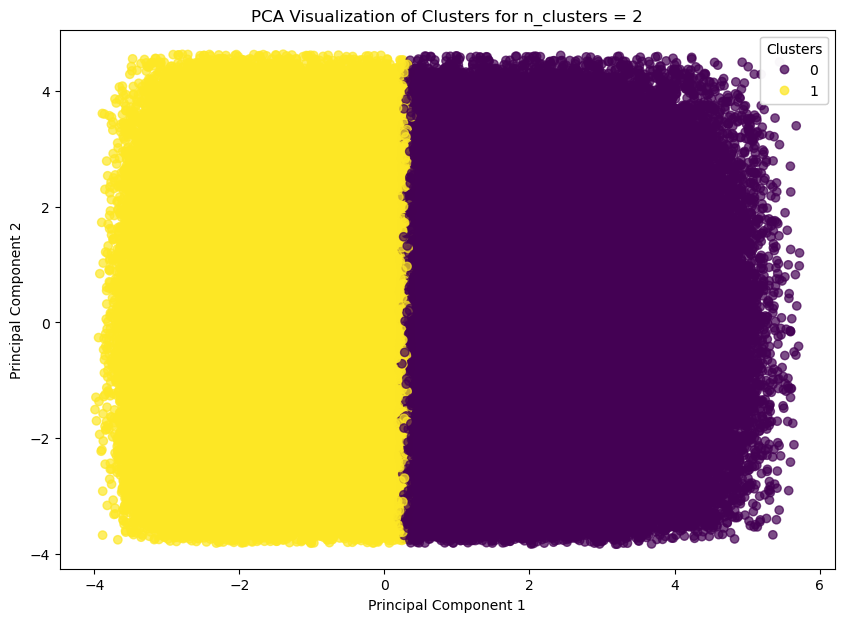

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


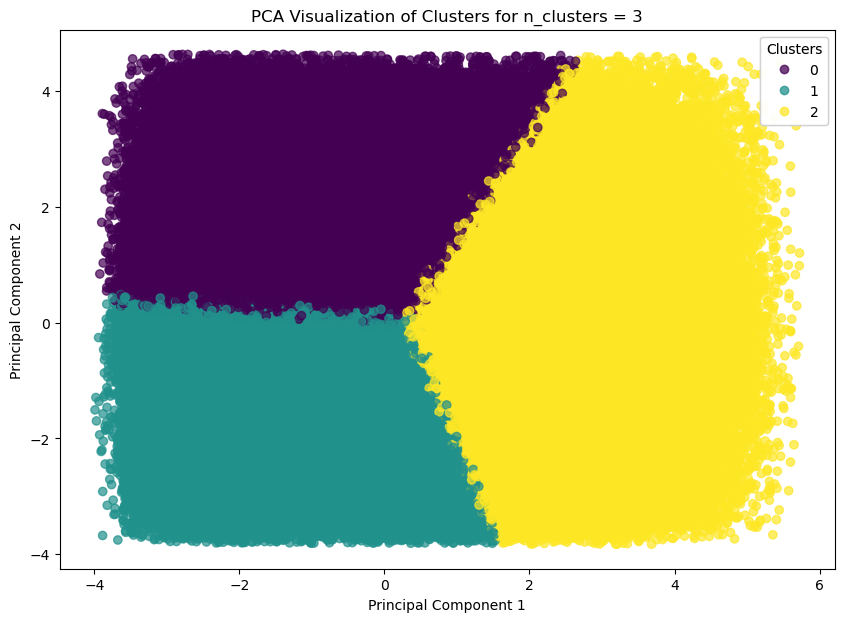

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


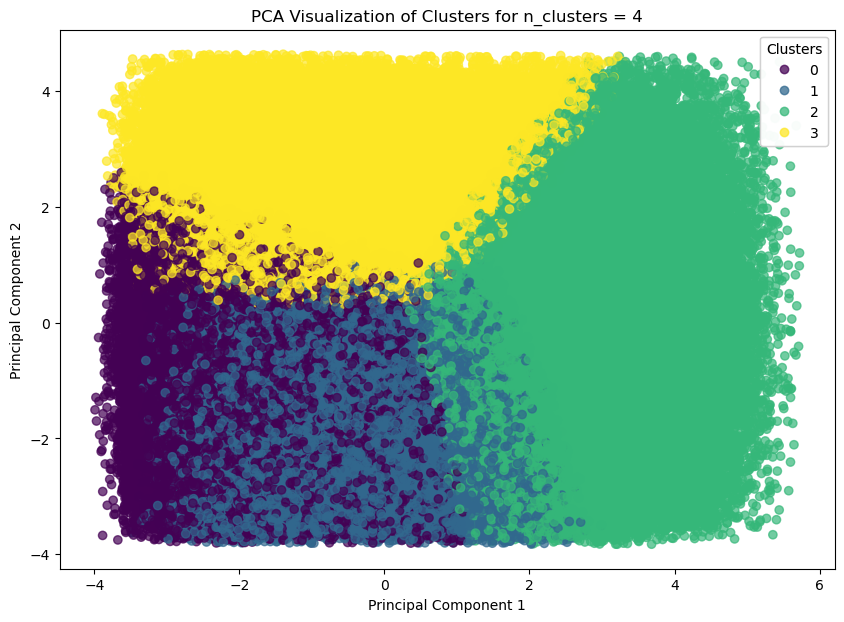

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


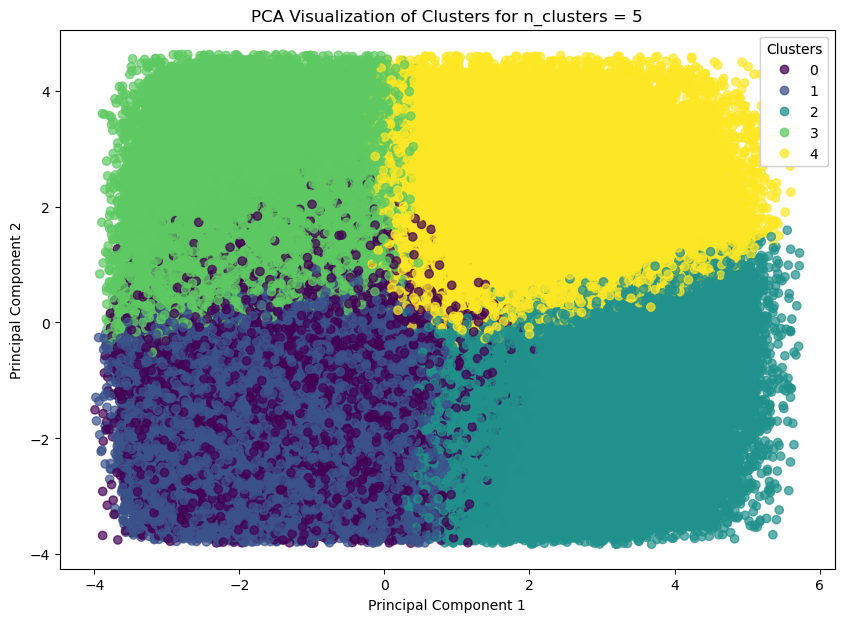

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


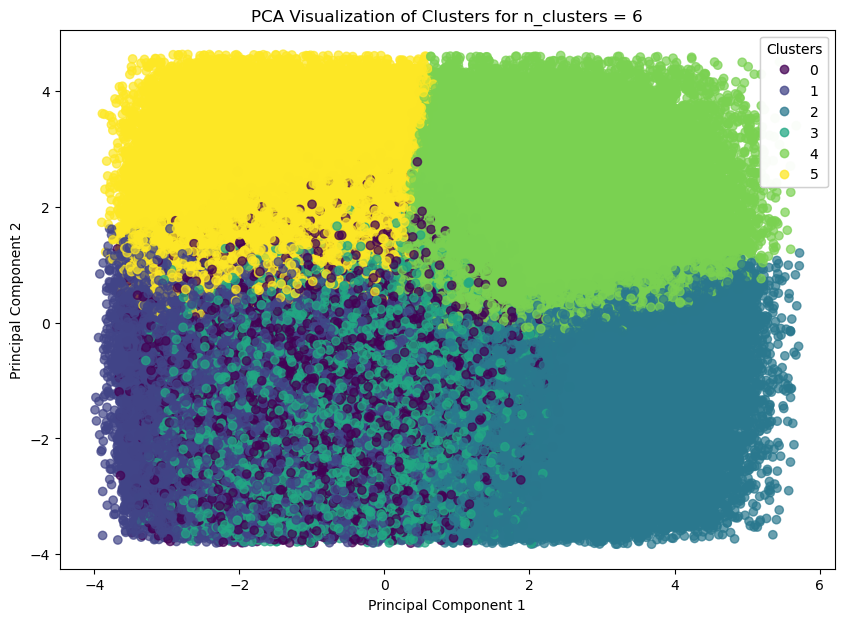

In [10]:

def cluster_and_plot(data, cluster_list, outcome_col='Outcome'):
    """#chat made this for me
    For each n_clusters in cluster_list, this function:
      - Drops the outcome column from data to create features.
      - Builds a pipeline with a preprocessor (scaling numerical and one-hot encoding categorical features)
        and KMeans clustering with n_clusters.
      - Attaches the resulting cluster labels to a new dataframe (a copy of the original data).
      - Plots a PCA visualization of the clustering results.
      
    Parameters:
      data         : Original DataFrame (including the outcome column).
      cluster_list : List of integers specifying the number of clusters to try (e.g., [2,3,4,5,6]).
      outcome_col  : Name of the target column to drop for clustering (default 'Outcome').
      
    Returns:
      A dictionary where keys are n_clusters values and values are the new dataframes with a 'cluster' column.
    """
    features = data.drop(columns=[outcome_col])
    
    num_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = features.select_dtypes(include=['object']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    
    result_dfs = {}
    
    for n in cluster_list:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(n_clusters=n, random_state=42))
        ])
        
        pipeline.fit(features)
        
        new_df = data.copy()
        new_df['cluster'] = pipeline.predict(features)
        result_dfs[n] = new_df


        #chat did the plotting
        features_no_cluster = features.copy()
        X_transformed = pipeline.named_steps['preprocessor'].transform(features_no_cluster)
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()
        
        # Reduce dimensions to 2 using PCA.
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_transformed)
        
        # Create a scatter plot of the clusters.
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=new_df['cluster'], cmap='viridis', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA Visualization of Clusters for n_clusters = {n}')
        legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.gca().add_artist(legend1)
        plt.show()
        
    return result_dfs

# --- Example Usage ---
# Assuming you have a DataFrame called 'data' that includes the 'Outcome' column.
cluster_dfs = cluster_and_plot(data, cluster_list=[2, 3, 4, 5, 6], outcome_col='Outcome')

### 3 clusters seems to be the most effective atleast in two dimensions, 4 may be worth exploring in case of it being ok in higher dimension, 5 and 6 have to much overlap so might not be worth it.

In [18]:
#uset this dataset for models
data_3clusters = cluster_dfs[3]
data_3clusters.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,blood_pressure_age_ratio,bmi_age_ratio,stress_activity_ratio,log_income,risk_factor_count,age_cholesterol_interaction,age_blood_pressure_interaction,cluster,distance_to_centroid,is_typical
0,31,Male,194,162,71,22.9,0,1,0,0,...,5.225806,0.738710,0.166666,11.074591,1,6014,5022,2,6.151897,0
1,69,Male,208,148,93,33.9,1,1,0,0,...,2.144928,0.491304,5.999940,11.427084,2,14352,10212,1,4.460279,1
2,34,Female,132,161,94,34.0,0,0,1,1,...,4.735294,1.000000,2.999970,12.064227,3,4488,5474,2,5.785812,0
3,53,Male,268,134,91,35.0,0,1,1,0,...,2.528302,0.660377,0.499999,10.688804,3,14204,7102,0,5.769897,0
4,57,Female,203,140,75,30.1,0,1,0,0,...,2.456140,0.528070,0.249999,11.331464,2,11571,7980,0,5.279594,1


In [19]:
data_3clusters.dtypes

Age                                 int64
Gender                             object
Cholesterol                         int64
BloodPressure                       int64
HeartRate                           int64
BMI                               float64
Smoker                              int64
Diabetes                            int64
Hypertension                        int64
FamilyHistory                       int64
PhysicalActivity                    int64
AlcoholConsumption                  int64
Diet                               object
StressLevel                         int64
Ethnicity                          object
Income                              int64
EducationLevel                     object
Medication                         object
ChestPainType                      object
ECGResults                         object
MaxHeartRate                        int64
ST_Depression                     float64
ExerciseInducedAngina              object
Slope                             

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372974 entries, 0 to 372973
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Age                             372974 non-null  int64  
 1   Gender                          372974 non-null  object 
 2   Cholesterol                     372974 non-null  int64  
 3   BloodPressure                   372974 non-null  int64  
 4   HeartRate                       372974 non-null  int64  
 5   BMI                             372974 non-null  float64
 6   Smoker                          372974 non-null  int64  
 7   Diabetes                        372974 non-null  int64  
 8   Hypertension                    372974 non-null  int64  
 9   FamilyHistory                   372974 non-null  int64  
 10  PhysicalActivity                372974 non-null  int64  
 11  AlcoholConsumption              372974 non-null  int64  
 12  Di

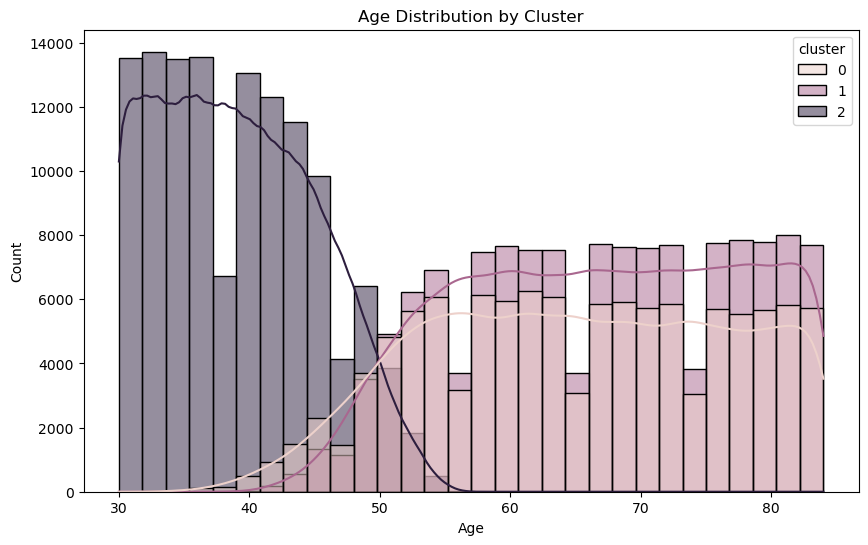

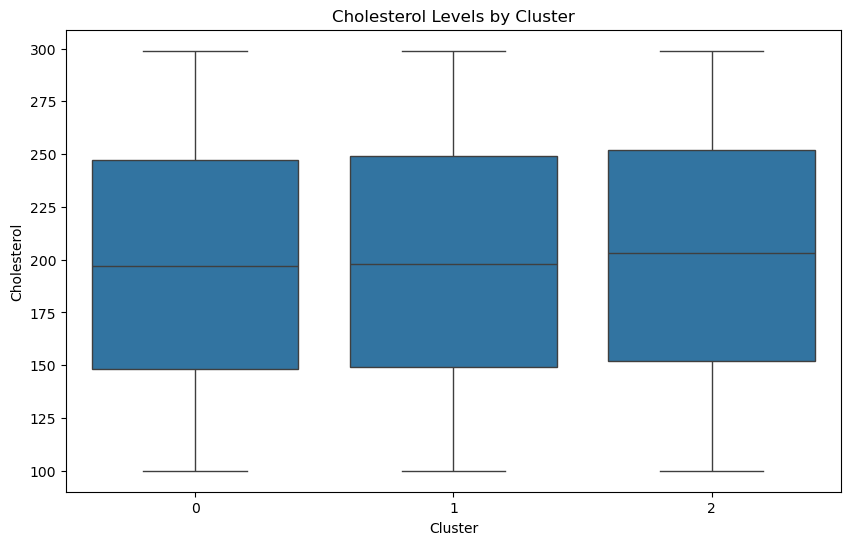

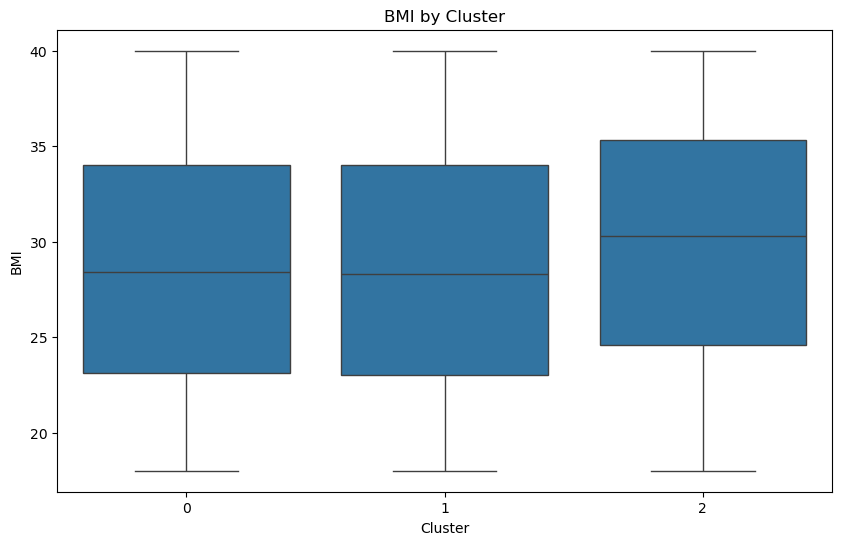

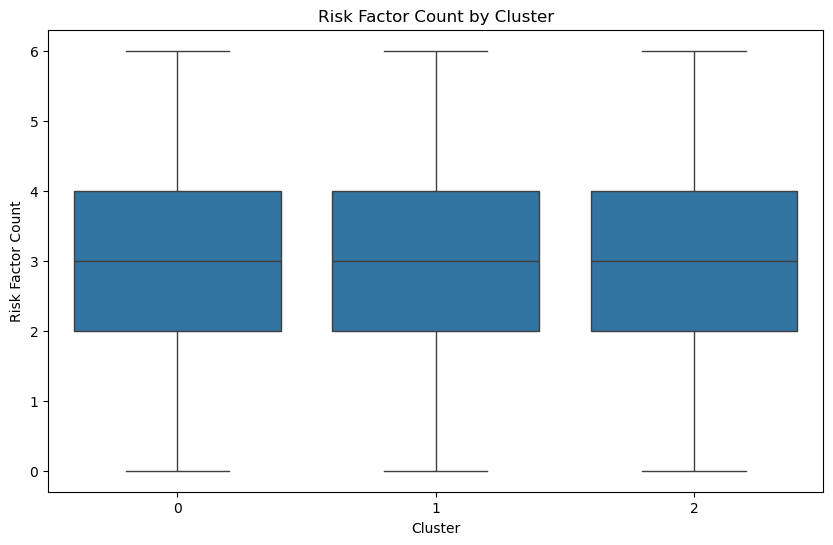

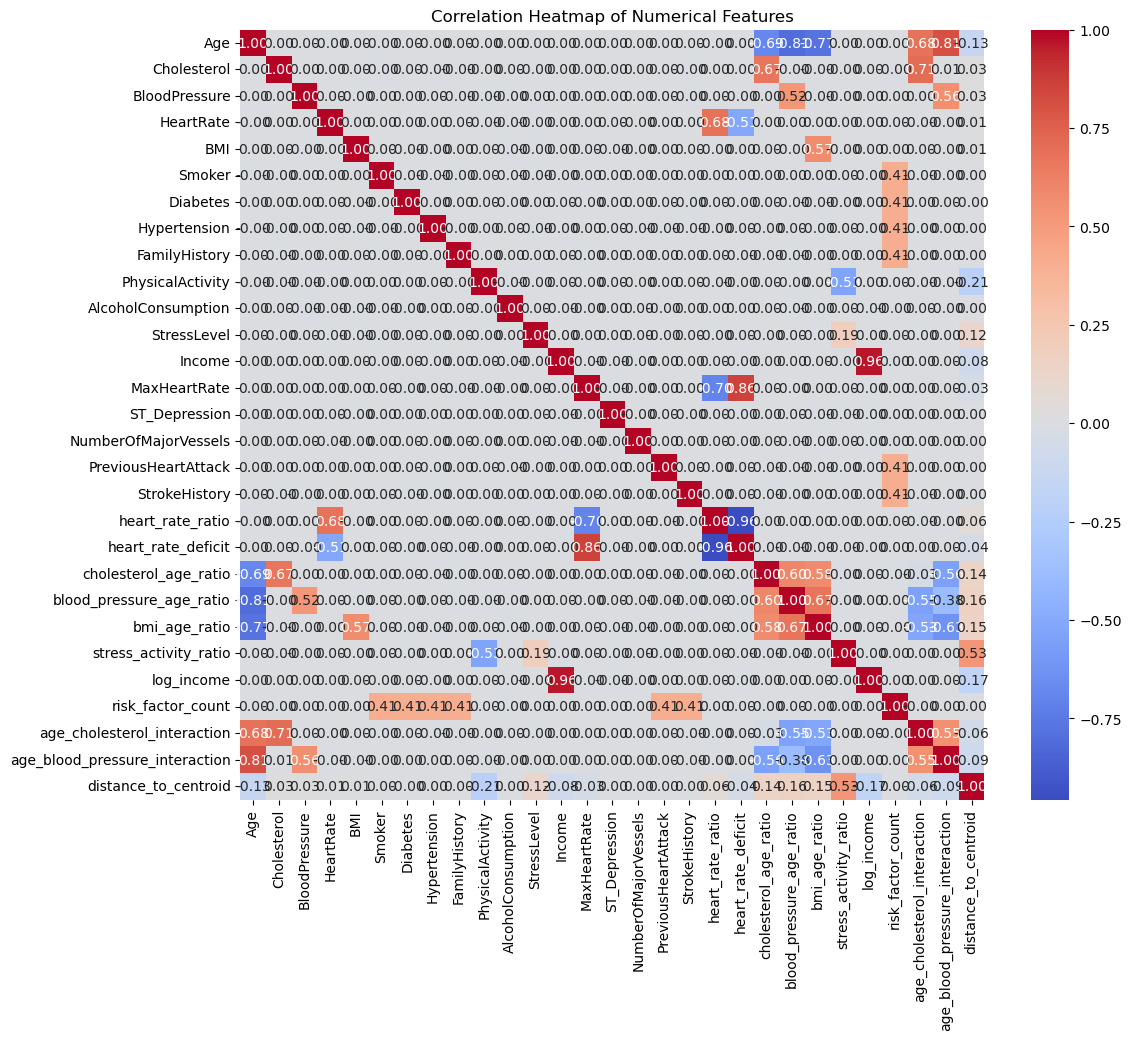

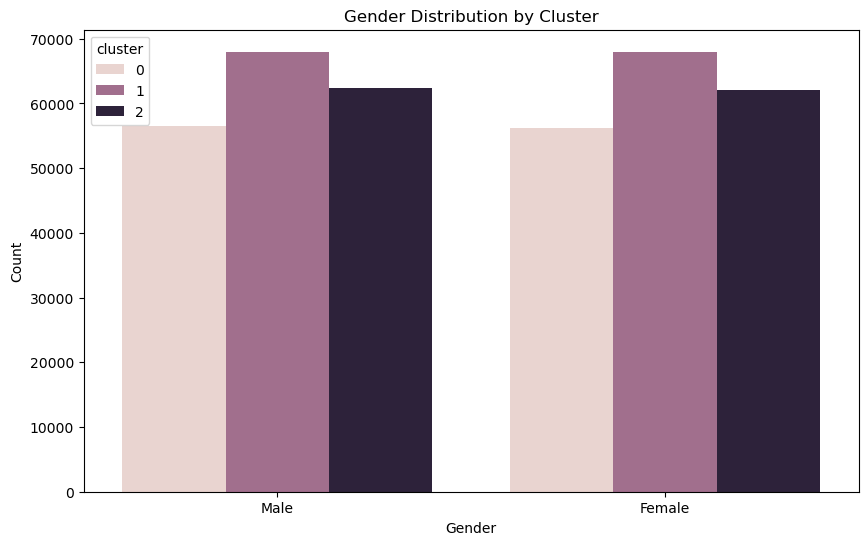

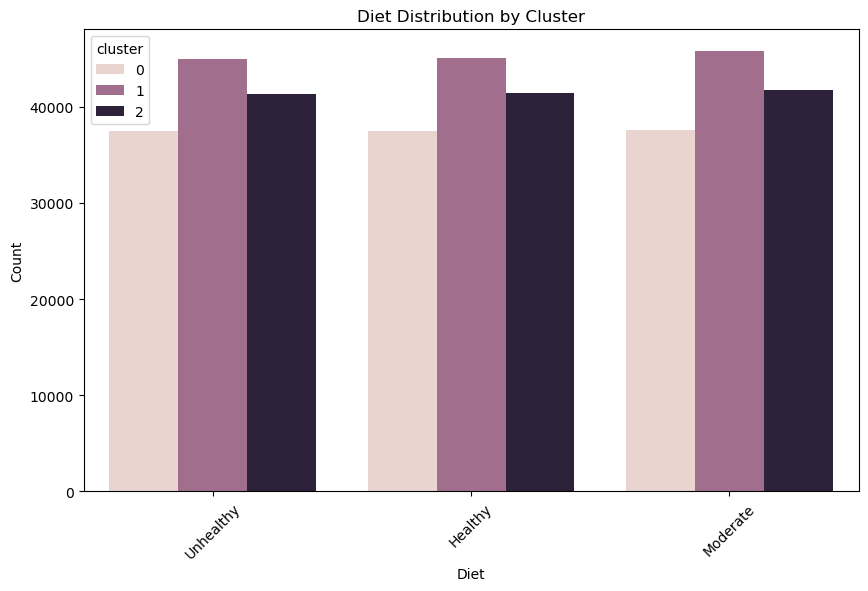

In [20]:
# Basic Dataset Overview
print("Dataset Info:")
print(data_3clusters.info())
print("\nSummary Statistics:")
print(data_3clusters.describe())

# Cluster Distribution
print("\nCluster Counts:")
print(data_3clusters['cluster'].value_counts())



plt.figure(figsize=(10, 6))
sns.histplot(data=data_3clusters, x='Age', hue='cluster', kde=True, bins=30)
plt.title("Age Distribution by Cluster")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='Cholesterol', data=data_3clusters)
plt.title("Cholesterol Levels by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cholesterol")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='BMI', data=data_3clusters)
plt.title("BMI by Cluster")
plt.xlabel("Cluster")
plt.ylabel("BMI")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='risk_factor_count', data=data_3clusters)
plt.title("Risk Factor Count by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Risk Factor Count")
plt.show()

plt.figure(figsize=(12, 10))
corr_matrix = data_3clusters.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='cluster', data=data_3clusters)
plt.title("Gender Distribution by Cluster")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Diet', hue='cluster', data=data_3clusters)
plt.title("Diet Distribution by Cluster")
plt.xlabel("Diet")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [21]:
# -----------------------------------------------------------------
# Re-define the preprocessor and pipeline using data_3clusters
# -----------------------------------------------------------------

# Prepare the features used in clustering: drop Outcome and cluster columns.
features_for_transformation = data_3clusters.drop(columns=['Outcome', 'cluster'])

# Identify numerical and categorical features.
num_features = features_for_transformation.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = features_for_transformation.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Define the pipeline with the preprocessor and KMeans (n_clusters = 3).
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit the pipeline on the features.
pipeline.fit(features_for_transformation)

# -----------------------------------------------------------------
# Compute new features based on the clustering results.
# -----------------------------------------------------------------

# 1. Distance to Cluster Centroid
# Transform the features using the preprocessor.
X_transformed = pipeline.named_steps['preprocessor'].transform(features_for_transformation)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Compute distances from each sample to each cluster centroid.
distances = pipeline.named_steps['kmeans'].transform(X_transformed)
# Get the assigned clusters (from your data_3clusters) as a numpy array.
assigned_clusters = data_3clusters['cluster'].values
# For each sample, extract the distance corresponding to its assigned cluster.
distance_to_centroid = np.array([distances[i, assigned_clusters[i]] for i in range(len(assigned_clusters))])
data_3clusters['distance_to_centroid'] = distance_to_centroid

# 2. Is Typical Flag
# Create a binary flag: 1 if a sample's distance is below (or equal to) the median distance; else 0.
median_distance = data_3clusters['distance_to_centroid'].median()
data_3clusters['is_typical'] = (data_3clusters['distance_to_centroid'] <= median_distance).astype(int)

# 3. Difference from Cluster Mean for Selected Features (e.g., Age and Cholesterol)
# Compute cluster-level means.
cluster_age_mean = data_3clusters.groupby('cluster')['Age'].mean().rename('cluster_age_mean')
cluster_chol_mean = data_3clusters.groupby('cluster')['Cholesterol'].mean().rename('cluster_cholesterol_mean')

# Merge the cluster means back into the dataframe.
data_3clusters = data_3clusters.merge(cluster_age_mean, left_on='cluster', right_index=True, how='left')
data_3clusters = data_3clusters.merge(cluster_chol_mean, left_on='cluster', right_index=True, how='left')

# Compute differences between individual values and their cluster means.
data_3clusters['age_diff_from_cluster_mean'] = data_3clusters['Age'] - data_3clusters['cluster_age_mean']
data_3clusters['cholesterol_diff_from_cluster_mean'] = data_3clusters['Cholesterol'] - data_3clusters['cluster_cholesterol_mean']

# -----------------------------------------------------------------
# Display the new features in the updated DataFrame.
# -----------------------------------------------------------------
data_3clusters.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,risk_factor_count,age_cholesterol_interaction,age_blood_pressure_interaction,cluster,distance_to_centroid,is_typical,cluster_age_mean,cluster_cholesterol_mean,age_diff_from_cluster_mean,cholesterol_diff_from_cluster_mean
0,31,Male,194,162,71,22.9,0,1,0,0,...,1,6014,5022,2,8.374336,0,39.139674,201.637180,-8.139674,-7.637180
1,69,Male,208,148,93,33.9,1,1,0,0,...,2,14352,10212,1,6.516271,1,66.675981,198.793628,2.324019,9.206372
2,34,Female,132,161,94,34.0,0,0,1,1,...,3,4488,5474,2,7.090183,0,39.139674,201.637180,-5.139674,-69.637180
3,53,Male,268,134,91,35.0,0,1,1,0,...,3,14204,7102,0,6.900697,0,64.980026,197.844038,-11.980026,70.155962
4,57,Female,203,140,75,30.1,0,1,0,0,...,2,11571,7980,0,5.377549,1,64.980026,197.844038,-7.980026,5.155962


In [23]:
data_3clusters.dtypes

Age                                     int64
Gender                                 object
Cholesterol                             int64
BloodPressure                           int64
HeartRate                               int64
BMI                                   float64
Smoker                                  int64
Diabetes                                int64
Hypertension                            int64
FamilyHistory                           int64
PhysicalActivity                        int64
AlcoholConsumption                      int64
Diet                                   object
StressLevel                             int64
Ethnicity                              object
Income                                  int64
EducationLevel                         object
Medication                             object
ChestPainType                          object
ECGResults                             object
MaxHeartRate                            int64
ST_Depression                     

In [25]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), num_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
#     ]
# )

#use this as the processor for the dataset 
#if decision tree doesnt allow this then youll have to do it manually